# Hypertune K-Means algorithm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Model processing

In [ ]:
# Imports
import seaborn as sns
import csv
import pandas as pd
import string

import numpy as np
import matplotlib.pyplot as plt
import pprint
import datetime
import glob
import numpy as np

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score

from sklearn.linear_model import LassoCV, Lasso
from sklearn.metrics import mean_squared_log_error

In [ ]:
data_dir_csv = '/content/drive/MyDrive/311Colab/311_calls/311_csv/'

In [ ]:
meta_311 = pd.read_csv(data_dir_csv + 'meta_311.csv', index_col=0)

In [ ]:
meta_311.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2567581 entries, 2 to 163838
Data columns (total 11 columns):
 #   Column         Dtype  
---  ------         -----  
 0   DUE            int64  
 1   OVERDUE        float64
 2   NEIGHBORHOOD   float64
 3   DEPARTMENT     float64
 4   DIVISION       float64
 5   QUEUE          float64
 6   Channel Type   float64
 7   Zip            float64
 8   scd_day_cos    float64
 9   scd_month_sin  float64
 10  scd_month_cos  float64
dtypes: float64(10), int64(1)
memory usage: 235.1 MB


In [ ]:
meta_311.head(5)

,DUE,OVERDUE,NEIGHBORHOOD,DEPARTMENT,DIVISION,QUEUE,Channel Type,Zip,scd_day_cos,scd_month_sin,scd_month_cos
2,0,-14.99,-1.093571,-0.315375,-0.427605,-0.240001,0.264298,-1.267736,0.625411,-0.5,0.866025
3,0,-14.99,-1.093571,-0.315375,-0.427605,-0.240001,0.264298,-1.267736,0.625411,-0.5,0.866025
5,0,-158.39,-1.093571,-0.315375,-0.427605,-0.240001,0.264298,-1.267736,0.625411,-0.5,0.866025
10,1,48.47,-0.395136,-0.102750,0.507442,-0.057630,0.264298,-0.684736,0.625411,-0.5,0.866025
12,0,-2.79,1.479609,0.747748,-1.362653,0.567639,0.264298,-0.408579,0.625411,-0.5,0.866025


## split data into train/valid/test


In [ ]:
X_vals = meta_311.drop(['DUE','OVERDUE'], axis=1)

# values as 0/1: 0 -> Not overdue   1 -> overdue
y_vals_class = meta_311[['DUE']]

# actual values for overdue
y_vals_reg = meta_311[['OVERDUE']]


In [ ]:
# Regression- split dataset into validation set and testing sets (50% each)
X_train_reg, X_valtest, y_train_reg, y_valtest = train_test_split(X_vals, y_vals_reg, test_size=0.3, random_state=20)
X_valid_reg, X_test_reg, y_valid_reg, y_test_reg = train_test_split(X_valtest, y_valtest, test_size=0.25, random_state=42)

# Classification split dataset into validation set and testing sets (50% each)
X_train_class, X_valtest, y_train_class, y_valtest = train_test_split(X_vals, y_vals_class, test_size=0.3, random_state=20, stratify=y_vals_class)
X_valid_class, X_test_class, y_valid_class, y_test_class = train_test_split(X_valtest, y_valtest, test_size=0.25, random_state=42, stratify=y_valtest)


In [ ]:
print("Classification Data")
print("training shape", X_train_class.shape, y_train_class.shape)
print("Validation shape", X_valid_class.shape, y_valid_class.shape)
print("Test shape", X_test_class.shape, y_test_class.shape)
print()
print("Regression Data")
print("training shape", X_train_reg.shape, y_train_reg.shape)
print("Validation shape", X_valid_reg.shape, y_valid_reg.shape)
print("Test shape", X_test_reg.shape, y_test_reg.shape)

Classification Data
training shape (1797306, 9) (1797306, 1)
Validation shape (577706, 9) (577706, 1)
Test shape (192569, 9) (192569, 1)

Regression Data
training shape (1797306, 9) (1797306, 1)
Validation shape (577706, 9) (577706, 1)
Test shape (192569, 9) (192569, 1)


In [ ]:
#y values Data need to be ravel --> (-1,)
y_train_reg = np.array(y_train_reg.values.tolist()).ravel()
y_valid_reg = np.array(y_valid_reg.values.tolist()).ravel()
y_test_reg = np.array(y_test_reg.values.tolist()).ravel()

y_train_class = np.array(y_train_class.values.tolist()).ravel()
y_valid_class = np.array(y_valid_class.values.tolist()).ravel()
y_test_class = np.array(y_test_class.values.tolist()).ravel()

# Unsupervised Learning Algorithm
## K-Means

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, MiniBatchKMeans

In [ ]:
ds_unsupervised = pd.read_csv(data_dir_csv + "ds_unsupervised.csv", index_col=0)

In [ ]:
ds_unsupervised = ds_unsupervised[['OVERDUE','LATITUDE','LONGITUDE']]

In [ ]:
ds_unsupervised.head(5)

,OVERDUE,LATITUDE,LONGITUDE
10,48.47,29.694706,-95.338928
14,3.11,29.630333,-95.464071
17,42.91,29.587757,-95.457265
19,1.06,29.823769,-95.363857
25,43.06,29.677567,-95.281319


In [ ]:
ds_unsupervised.describe()

,OVERDUE,LATITUDE,LONGITUDE
count,687771.000000,687771.000000,687771.000000
mean,31.543267,29.746440,-95.391219
std,56.259167,0.093542,0.106865
min,0.010000,29.455842,-95.924906
25%,1.840000,29.676549,-95.468471
50%,7.730000,29.742657,-95.382986
75%,28.910000,29.807616,-95.321039
max,228.570233,30.099405,-94.922661


In [ ]:
#standardize data
scaler = StandardScaler()
ds_scale = scaler.fit_transform(ds_unsupervised)

# statistics of scaled data
pd.DataFrame(ds_scale).describe()

,0,1,2
count,6.877710e+05,6.877710e+05,6.877710e+05
mean,-3.312562e-16,3.612065e-14,3.757279e-14
std,1.000001e+00,1.000001e+00,1.000001e+00
min,-5.605005e-01,-3.106599e+00,-4.994032e+00
25%,-5.279724e-01,-7.471572e-01,-7.229002e-01
50%,-4.232783e-01,-4.044076e-02,7.703693e-02
75%,-4.680603e-02,6.540015e-01,6.567096e-01
max,3.502133e+00,3.773335e+00,4.384572e+00


*defining the kmeans function with initialization as k-means++
‘k-means++’ : selects initial cluster centroids using sampling based
 on an empirical probability distribution of the points contribution to the overall inertia*

In [ ]:
kmeans = MiniBatchKMeans(n_clusters=9, init='k-means++', tol=0.001, max_iter=10000)
# fitting the k means algorithm on unscaled data
kmeans.fit(ds_unsupervised)
pred = kmeans.predict(ds_unsupervised)

In [ ]:
#value count of points in each of the clusters
frame = pd.DataFrame(ds_unsupervised)
frame['cluster'] = pred
frame['cluster'].value_counts()

0    384062
5    118868
3     55549
7     33906
1     33137
2     26369
6     16443
4     12344
8      7093
Name: cluster, dtype: int64

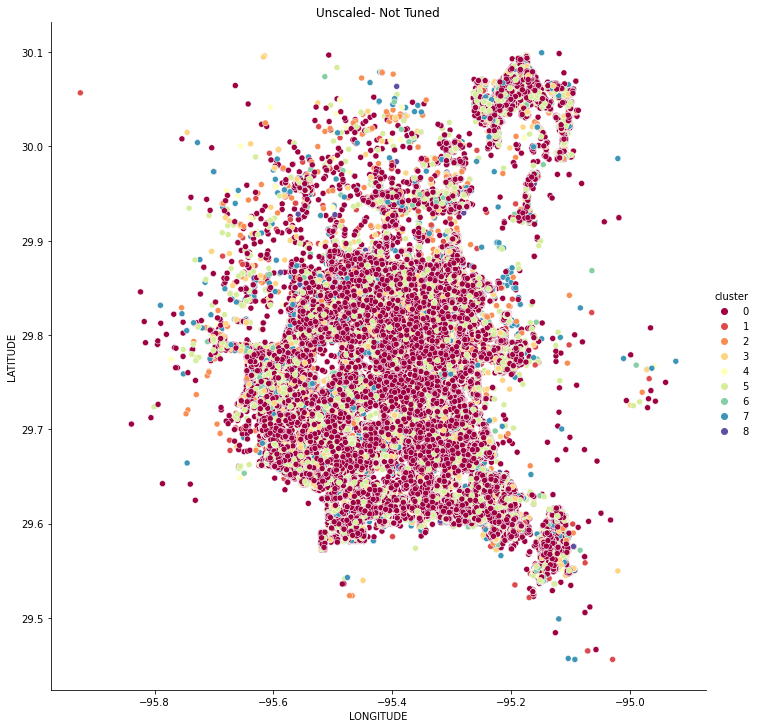

In [ ]:
#scatter plot that shows the geographic distribution of the clusters
sns.relplot(x="LONGITUDE", y="LATITUDE", hue="cluster", data=frame, height=10, palette="Spectral", legend='full').set(title='Unscaled- Not Tuned')

Tune Unscaled model

Text(0, 0.5, 'Inertia')

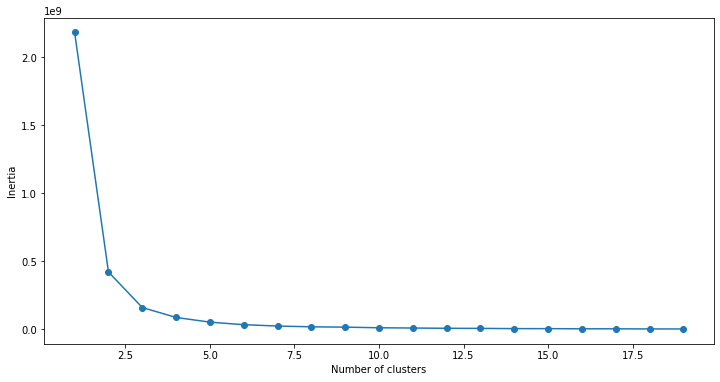

In [ ]:
# UNSCALED
# store inertia values into list
SSE = []
for cluster in range(1,20):
    kmeans = MiniBatchKMeans(n_clusters=cluster, init='k-means++', max_iter=10000, tol=0.001)
    kmeans.fit(ds_unsupervised)
    SSE.append(kmeans.inertia_)

# converting the results into a dataframe and plotting inertia values vs # of clusters
frame = pd.DataFrame({'Cluster':range(1,20), 'SSE':SSE})
plt.figure(figsize=(12,6))
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

In [ ]:
# UNSCALED
# k means using OPTIMAL clusters and k-means++ initialization
kmeans = MiniBatchKMeans(n_clusters=3, init='k-means++', max_iter=10000, tol=0.001)
kmeans.fit(ds_unsupervised)
pred = kmeans.predict(ds_unsupervised)

In [ ]:
#value count of points in each of the clusters
frame = pd.DataFrame(ds_unsupervised)
frame['cluster'] = pred
frame['cluster'].value_counts()

0    544821
2     90847
1     52103
Name: cluster, dtype: int64

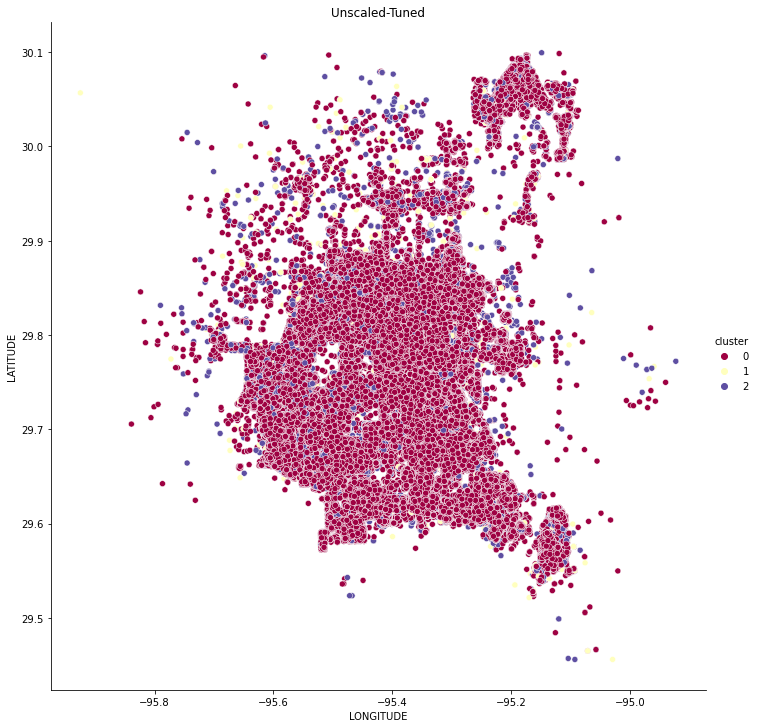

In [ ]:
#scatter plot that shows the geographic distribution of the clusters
sns.relplot(x="LONGITUDE", y="LATITUDE", hue="cluster", data=frame, height=10, palette="Spectral", legend='full').set(title='Unscaled-Tuned')

The data for the unsupervised algorithm consists of all positive overdue calls. The data consists of the city of Houston's geographical location which is between -94.75 to -96 longitude and 29.3 to 30.1 latitude. Since the numbers are not too spread out we will not add any scaling to this first model instance. The goal is to find a similarity in regions based on the latitude and longitude of the service request based on the overdue value.  For the Mini Batch K-Means algorithm the initial value for K for the un-scaled model is 9.

Scaled model - Not tuned

In [ ]:
kmeans_scaled = MiniBatchKMeans(n_clusters=9, init='k-means++', tol=0.001, max_iter=10000)
# fitting the k means algorithm on scaled data
kmeans_scaled.fit(ds_scale)
pred2 = kmeans_scaled.predict(ds_scale)

In [ ]:
#value count of points in each of the clusters
frame = pd.DataFrame(ds_scale)
frame['cluster'] = pred2
frame['cluster'].value_counts()

1    125810
2    122048
5    116477
8    100823
4     71300
0     57589
3     41110
7     35991
6     16623
Name: cluster, dtype: int64

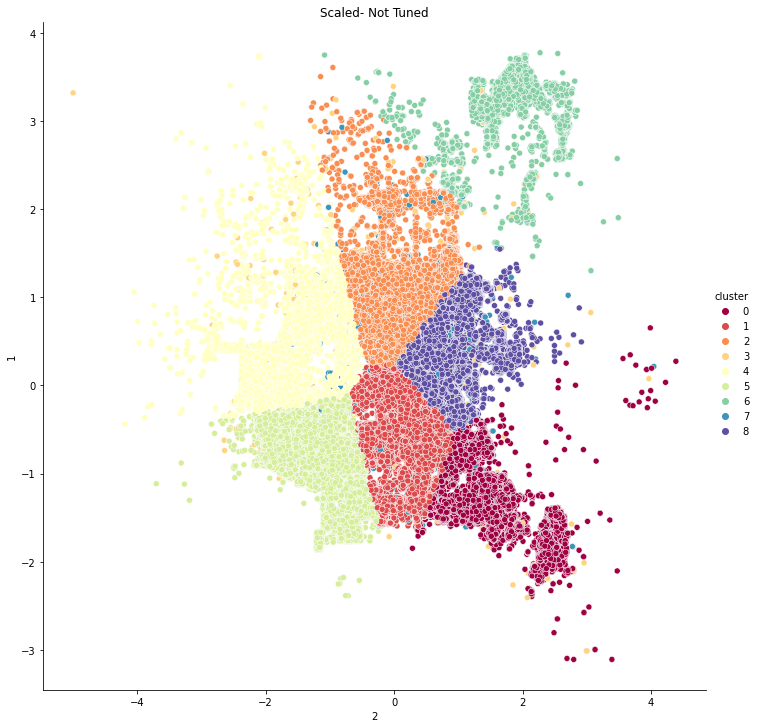

In [ ]:
#scatter plot that shows the geographic distribution of the clusters
sns.relplot(x=frame[2], y=frame[1], hue="cluster", data=frame, height=10, palette="Spectral", legend='full').set(title='Scaled- Not Tuned')

The scaled data shows more concise clusters. We are able to distinguish different regions of Houston which was what we were aiming for. Using the elbow method, the optimal value for k is  11.

Text(0, 0.5, 'Inertia')

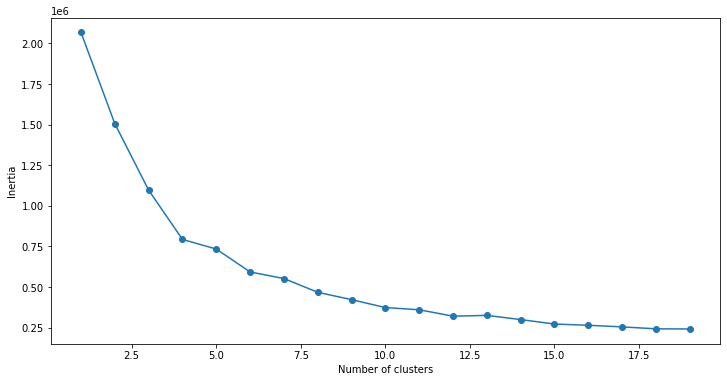

In [ ]:
# store inertia values into list
SSE = []
for cluster in range(1,20):
    kmeans_scaled = MiniBatchKMeans(n_clusters=cluster, init='k-means++', max_iter=10000, tol=0.001)
    kmeans_scaled.fit(ds_scale)
    SSE.append(kmeans_scaled.inertia_)

# converting the results into a dataframe and plotting inertia values vs # of clusters
frame = pd.DataFrame({'Cluster':range(1,20), 'SSE':SSE})
plt.figure(figsize=(12,6))
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

Scaled model Tuned

In [ ]:
# SCALED
# k means using OPTIMAL clusters and k-means++ initialization
kmeans_scaled = MiniBatchKMeans(random_state=10, n_clusters=11, init='k-means++', max_iter=10000, tol=0.00001)
kmeans_scaled.fit(ds_scale)
pred2 = kmeans_scaled.predict(ds_scale)

In [ ]:
#value count of points in each of the clusters
frame = pd.DataFrame(ds_scale)
frame['cluster'] = pred2
frame['cluster'].value_counts()

7     120116
8     101734
0      85097
3      69693
1      62992
6      61301
10     58229
9      40273
5      36664
2      36366
4      15306
Name: cluster, dtype: int64

In [ ]:
frame

,0,1,2,cluster
0,0.300871,-0.553055,0.489311,1
1,-0.505398,-1.241232,-0.681719,8
2,0.202042,-1.696384,-0.618039,8
3,-0.541837,0.826679,0.256040,6
4,0.204709,-0.736277,1.028391,10
...,...,...,...,...
687766,-0.524595,0.085097,-0.735333,7
687767,-0.352001,-0.496460,-0.782121,8
687768,-0.533838,0.341667,-1.484876,3
687769,-0.553746,0.112892,0.274351,7


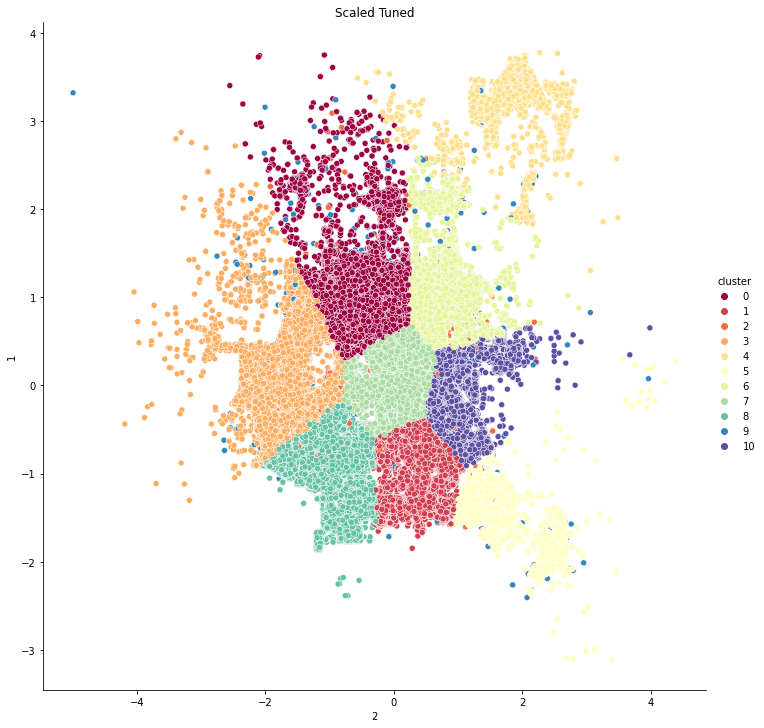

In [ ]:
#scatter plot that shows the geographic distribution of the clusters
sns.relplot(x=frame[2], y=frame[1], hue="cluster", data=frame, height=10, palette="Spectral", legend='full').set(title='Scaled Tuned')

Clusters all around the city of Houston are well visualized. The scaled model can successfully identify different regions of the city of Houston in clusters. For future work the data could be modified to include the day of the week the service request was created and see if there could be any impact on the service being overdue rather than geographical locations.
